In [52]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

Testing model and graphing predictions

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
# train = pd.read_csv('drive/MyDrive/Neural Networks/Neural Networks Project/stocky/Datasets/Processed Data/normalized_training_data.csv')
# test = pd.read_csv('drive/MyDrive/Neural Networks/Neural Networks Project/stocky/Datasets/Processed Data/normalized_testing_data.csv')
train = pd.read_csv('normalized_training_data.csv')
test = pd.read_csv('normalized_testing_data.csv')

In [82]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [103]:
class customLSTM():
    def __init__(self, prediction_metric, n_features, n_steps = 50):
        self.n_steps = n_steps
        self.prediction_metric = prediction_metric
        self.model = Sequential()
        self.model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mse')

    def sequence_df(self, df):
        ins = []
        out = []
        for col in df.columns:
            if col == self.prediction_metric:
                out = array(df[col][:-1])
                out = np.insert(out, 0, 0)
                out = out.reshape((len(out), 1))
            elif col != 'Date':
                c = array(df[col])
                c = c.reshape((len(c), 1))
                ins.append(c)

        ins.append(out)
        data = hstack(tuple(ins))
        X, y = split_sequences(data, self.n_steps)
        return X, y

    def train(self, df, epochs = 50, verbose = 1):
        self.trainingset = df
        self.Xtrain, self.Ytrain = self.sequence_df(df)
        self.model.fit(self.Xtrain, self.Ytrain, epochs = epochs, verbose = verbose)

    def test(self, df, verbose = 1):
        self.testingset = df
        self.Xtest, self.Yactual = self.sequence_df(df)
        self.Ypredicted = self.model.predict(self.Xtest, verbose=verbose)

    def plotResults(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.Ypredicted, label='Predicted')
        plt.plot(self.Yactual, label='Actual')

        dates = list(self.testingset['Date'][self.n_steps+1:])
        plt.xticks(range(0, len(dates), 20), dates[::20], rotation=70)

        plt.title('Predicted vs Actual Values')
        plt.xlabel('Date')
        plt.legend()
        plt.show()

In [ ]:
model = customLSTM('Price', len(train.columns) - 2, n_steps=50)
model.train(train, epochs=50, verbose=0)

AttributeError: module 'matplotlib.pyplot' has no attribute 'xaxis'

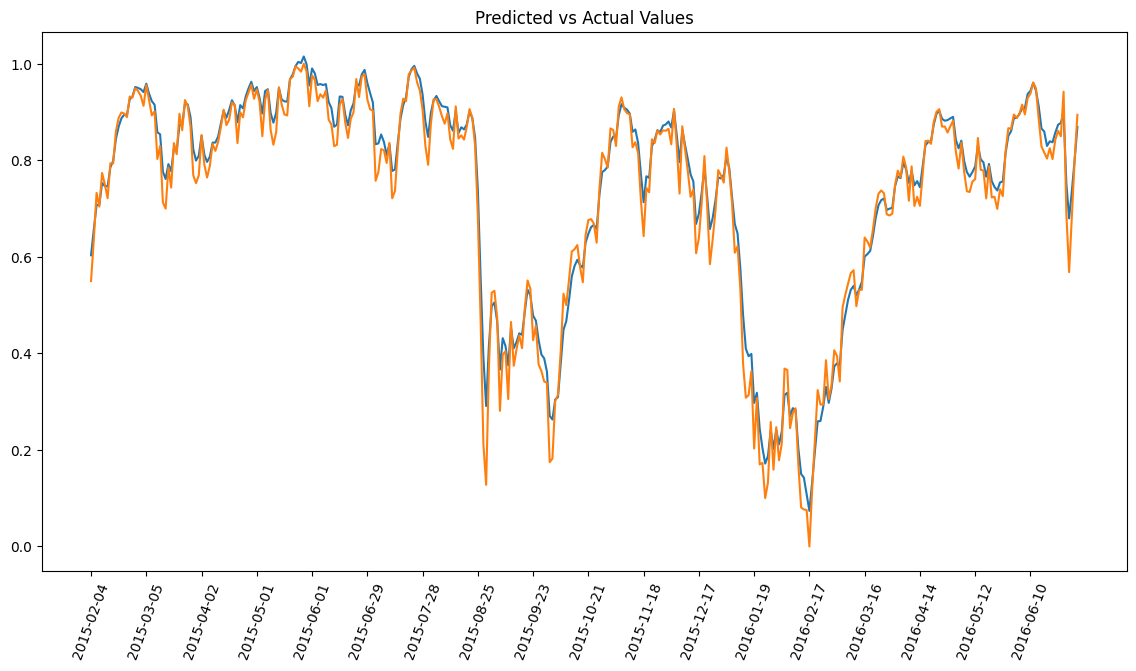

In [104]:
model.test(test, verbose=0)
model.plotResults()